# Verarbeiten großer Dateien

Groß ist relativ:

1. richtig groß: Datensatz ist so groß, dass er nicht mehr in den Auslagerungsspeicher passt. Die Dateien liegen verteilt auf Systemen vor.
2. sehr groß: Datensatz passt in den Auslagerungsspeicher (Festplatte), nicht aber in den Arbeitsspeicher des Rechners.
3. groß: Datensatz passt in den Arbeitsspeicher
4. klein: Datensatz belegt nur einen kleinen Teil des Arbeitsspeichers.

Die Python-Bibliothek *Pandas* beherrscht 4) und 3), sofern man Wartezeiten in Kauf nimmt. Alternativen sind *Dask* oder *Vaex*. Auch sie können nicht zaubern und brauchen Anweisungen, welche Ausschnitte des Datensatzes im Arbeitsspeicher verrechnet werden sollen. *Modin* unterstützt bei der Parallelisierung, wenn beispielsweise mehrere Rechenkerne zur Verfügung stehen.

Entsprechend dem *Map-Reduce* Prinzip kann auch Pandas große Datensätze verarbeiten, indem es Ausschnitte nacheinander läd.

Dazu ein Beispiel. 

Die Demodaten liegen als komprimierte Zip-Datei vor. Nur sie muss in den Auslagerungsspeicher passen, nicht aber die entpackte Datei.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fn = 'data/city_temperature.zip'


Der Zusatz `chunksize` legt die Größe des Datenpakets fest, die Pandas einlesen soll. Zurückgegeben wird ein Generatorobjekt 

In [4]:
chunksize = 10000

dfi = pd.read_csv(fn, dtype={'State':object}, compression='zip',  chunksize=chunksize)

type(dfi)


pandas.io.parsers.readers.TextFileReader

In [5]:
print('type: ', type(dfi))

counter = 0
for chunk in dfi:
    counter +=1

print('Number of chunks: ', counter, '; size (except last one): ', chunksize)

type:  <class 'pandas.io.parsers.readers.TextFileReader'>
Number of chunks:  291 ; size (except last one):  10000



&nbsp;

Hier soll untersucht werden, wie die Datei aufgebaut ist. Dazu werden die ersten Zeilen (`head()`) des ersten Chunk ausgegeben. 

Anschließend werden alle unterschiedlichen kategoralen Werte in den Spalten 0, 1 und 3 gesucht und als Zwischenergebnis zusammengeführt. Da sich die Chunks nicht an logische Grenzen der Dateistruktur halten, wird das Zwischenergebnis erneut auf Einzigartigkeit hin untersucht.

Aus dem Ergebnis-Dataframe werden die Länder pro Kontinent und alle Städte in Deutschland ausgegeben.


In [6]:
dfi = pd.read_csv(fn, dtype={'State':object}, compression='zip',  chunksize=10000)

first_el=True

dunique = pd.DataFrame()
for chunk in dfi:
    if first_el:
        display(chunk.head())
        first_el=False
    #"map"
    chunk = chunk.iloc[:, [0,1,3]]
    #"reduce"
    chunk = chunk[~chunk.duplicated()]
    dunique = pd.concat([dunique, chunk], axis=0)
    
dunique = dunique[~dunique.duplicated()]
print(dunique.groupby(['Region'])['Country'].apply(list))
cities_list = dunique.groupby(['Country'])['City'].apply(list)
cities_list['Germany']


,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


Region
Africa                               [Algeria, Burundi, Benin, Central African Repu...
Asia                                 [Bangladesh, China, China, China, China, China...
Australia/South Pacific              [Australia, Australia, Australia, Australia, A...
Europe                               [Albania, Austria, Belarus, Belgium, Bulgaria,...
Middle East                          [Bahrain, Israel, Jordan, Kuwait, Lebanon, Oma...
North America                        [Canada, Canada, Canada, Canada, Canada, Canad...
South/Central America & Carribean    [Argentina, Bahamas, Bermuda, Belize, Bolivia,...
Name: Country, dtype: object


['Bonn', 'Frankfurt', 'Hamburg', 'Munich']

&nbsp;

Manchmal möchte man einen schnellen Blick auf die Datei werfen. Auch hier hilft `chunksize`:

&nbsp;

In [7]:
chunksize = 6

dfi = pd.read_csv(fn, dtype={'State':object}, compression='zip',  chunksize=chunksize)
print('type: ', type(dfi))
display(next(dfi))

print('Next block:')
display(next(dfi))

type:  <class 'pandas.io.parsers.readers.TextFileReader'>


,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9
5,Africa,Algeria,NaN,Algiers,1,6,1995,48.7


Next block:


,Region,Country,State,City,Month,Day,Year,AvgTemperature
6,Africa,Algeria,NaN,Algiers,1,7,1995,48.9
7,Africa,Algeria,NaN,Algiers,1,8,1995,49.1
8,Africa,Algeria,NaN,Algiers,1,9,1995,49.0
9,Africa,Algeria,NaN,Algiers,1,10,1995,51.9
10,Africa,Algeria,NaN,Algiers,1,11,1995,51.7
11,Africa,Algeria,NaN,Algiers,1,12,1995,51.3


## dask: Erweiterung von Pandas

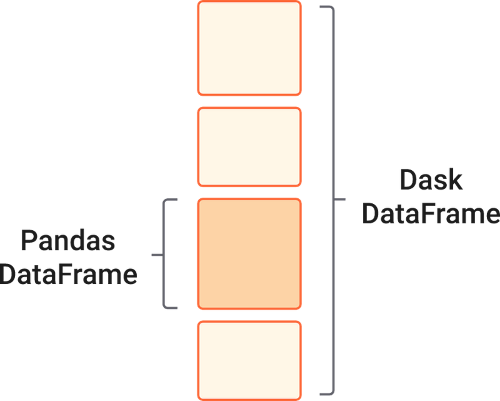

Idee: Datensatz aufteilen in Chunks, die parallel verrechnet werden.